## Kaggle Competition 

Compete in the [CPU Prediction](http://inclass.kaggle.com/c/model-t4/data) Kaggle competition.  It is a regression problem with a fair amount of features so Ridge and LASSO might work well.  Remember, try to use models you understand and do not be swayed to use overly complex algorithms.  Since it is still on going, you can submit your solution and get scored to compete against other data scientists!  Use what you have learned in the first 3 weeks of class to work your way up the leader board.

__If you want to organize a team from other students who have finished the sprint, feel free to make a team of 3-5 students__

## Tools: 

Before you dive into regression, algorithms and testing talk to your partner/team and devise a strategy for analyzing the data. Work effectively so that you can communicate your findings in a presentation. Use any of the tools we learnt this week (here are some suggestions...):

<u> Use EDA techniques: </u>

* Visualize the data set and understand your variables. 
* Look for the categorical and continuous regressors. 
* Use faceting or stratification to identify collinearity.

<u> Use the big guns:</u> 

* Linear regression
* Ridge regression
* Lasso regression 


<u>Remove biases in data using:</u>

* Detecting and reducing Multicollinearity 
* Heteroscedasticity
* Influence and leverage points, and outliers.

<u> Test your predictions: </u>

* Use cross validation and k-fold to test for overfitting

Good Luck!


In [303]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


from basis_expansions.basis_expansions import NaturalCubicSpline
from regression_tools.dftransformers import (
    ColumnSelector, Identity,
    FeatureUnion, MapFeature,
    StandardScaler)

from regression_tools.plotting_tools import (
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)


%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [15]:
def simple_spline_specification(name, knots):
    select_name = "{}_select".format(name)
    spline_name = "{}_spline".format(name)
    return Pipeline([
        (select_name, ColumnSelector(name=name)),
        (spline_name, NaturalCubicSpline(knots=knots))
    ])

def simple_indicator_specification(var_name, levels):
    select_name = "{}_select".format(var_name)
    map_features = []
    if not isinstance(levels, list):
        levels = [levels]
    for level in levels:
        indicator_name = "{}_{}_indicator".format(var_name, level)
        map_features.append(
            (indicator_name, MapFeature(lambda var: var == level, indicator_name))
        )
    return Pipeline([
        (select_name, ColumnSelector(name=var_name)),
        ("indicator_features", FeatureUnion(map_features))
    ])

In [48]:
def standardize_y(y_train, y_test):
    y_mean, y_std = np.mean(y_train), np.std(y_train)
    y_train_std = (y_train - y_mean) / y_std
    y_test_std = (y_test - y_mean) / y_std
    return y_train_std, y_test_std

In [46]:
raw_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [4]:
raw_data.head()

,sample_time,m_id,syst_direct_ipo_rate,syst_buffered_ipo_rate,syst_page_fault_rate,syst_page_read_ipo_rate,syst_process_count,syst_other_states,page_page_write_ipo_rate,page_global_valid_fault_rate,...,tcp_retxto,tcp_kpalv,lla0_pkts_recvpsec,lla0_pkts_sentpsec,llb0_pkts_recvpsec,llb0_pkts_sentpsec,ewc0_pkts_recvpsec,ewc0_pkts_sentpsec,ewd0_pkts_recvpsec,ewd0_pkts_sentpsec
0,2010-11-24 00:01:00,a,80.48,1261.97,15.55,2.10,271,12,6.23,4.67,...,0,0,464.483,463.167,67.433,89.183,382.533,327.983,380.783,412.833
1,2010-11-24 00:01:00,b,73.80,624.38,6.43,0.45,317,10,5.47,1.10,...,0,0,292.667,429.650,70.583,97.783,255.800,350.417,407.600,270.150
2,2010-11-24 00:01:00,c,40.57,466.18,6.40,0.45,258,22,10.90,1.10,...,0,0,359.917,404.550,16.450,21.883,356.083,266.717,231.483,276.150
3,2010-11-24 00:01:00,d,68.75,495.10,6.50,0.45,224,10,2.58,1.10,...,0,0,378.050,367.067,21.717,29.117,262.867,297.350,316.950,286.433
4,2010-11-24 00:01:00,e,47.45,436.65,6.42,0.45,253,10,2.48,1.10,...,0,0,374.050,369.217,24.750,34.033,368.317,293.133,292.283,308.933


In [55]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 89 columns):
sample_time                     50000 non-null object
m_id                            50000 non-null object
syst_direct_ipo_rate            50000 non-null float64
syst_buffered_ipo_rate          50000 non-null float64
syst_page_fault_rate            50000 non-null float64
syst_page_read_ipo_rate         50000 non-null float64
syst_process_count              50000 non-null int64
syst_other_states               50000 non-null int64
page_page_write_ipo_rate        50000 non-null float64
page_global_valid_fault_rate    50000 non-null float64
page_free_list_size             50000 non-null int64
page_modified_list_size         50000 non-null int64
io_mailbox_write_rate           50000 non-null float64
io_split_transfer_rate          50000 non-null float64
io_file_open_rate               50000 non-null float64
io_logical_name_trans           50000 non-null float64
io_page_reads        

This competition is part of a machine learning workshop given at InTraffic.

The goal is to predict the load on the CPUs in a cluster of servers based on the behavior of a series of applications running on these servers.

There are two CPUs in each server. There are seven servers in the cluster. The prediction is for the second CPU.

The dataset consists of a set of variables that were measured over about a one month period. Measurements were taken in one minute intervals and on each server. Measurements are usually the average or sum over that one minute interval. For instance the number of packets received, the average number of IO operations, etc

The set is data from a real cluster that is used to control train traffic in a geographical area spanning several cities.

Data fields

sample time - the date and time the data was sampled.  
m_id - the ID of the server the data was sampled at.  
appxxxx - data about specific application.  
pagexxx - data on memory usage of the server.  
syst_xxx - data on page fault rate, number of processes, etc.  
state_xxx - data on the state the system is in.  
io_xxx - data about general IO usage, (file IO, direct IO).  
tcp_xxx - data on incoming and outgoing TCP traffic.  
llxxx, ewxxx - data on incoming and outgoing network traffic.  
cpu_01_busy - the variable we are trying to predict.

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178780 entries, 0 to 178779
Data columns (total 89 columns):
sample_time                     178780 non-null object
m_id                            178780 non-null object
syst_direct_ipo_rate            178780 non-null float64
syst_buffered_ipo_rate          178780 non-null float64
syst_page_fault_rate            178780 non-null float64
syst_page_read_ipo_rate         178780 non-null float64
syst_process_count              178780 non-null int64
syst_other_states               178780 non-null int64
page_page_write_ipo_rate        178780 non-null float64
page_global_valid_fault_rate    178780 non-null float64
page_free_list_size             178780 non-null int64
page_modified_list_size         178780 non-null int64
io_mailbox_write_rate           178780 non-null float64
io_split_transfer_rate          178780 non-null float64
io_file_open_rate               178780 non-null float64
io_logical_name_trans           178780 non-null float64
io_

In [6]:
raw_data[raw_data.columns[0:10]]

,sample_time,m_id,syst_direct_ipo_rate,syst_buffered_ipo_rate,syst_page_fault_rate,syst_page_read_ipo_rate,syst_process_count,syst_other_states,page_page_write_ipo_rate,page_global_valid_fault_rate
0,2010-11-24 00:01:00,a,80.48,1261.97,15.55,2.10,271,12,6.23,4.67
1,2010-11-24 00:01:00,b,73.80,624.38,6.43,0.45,317,10,5.47,1.10
2,2010-11-24 00:01:00,c,40.57,466.18,6.40,0.45,258,22,10.90,1.10
3,2010-11-24 00:01:00,d,68.75,495.10,6.50,0.45,224,10,2.58,1.10
4,2010-11-24 00:01:00,e,47.45,436.65,6.42,0.45,253,10,2.48,1.10
5,2010-11-24 00:01:00,f,25.45,146.72,6.35,0.45,165,10,0.00,1.07
6,2010-11-24 00:01:00,g,42.78,623.82,6.40,0.45,217,2,4.33,1.10
7,2010-11-24 00:02:00,a,63.67,542.83,0.18,0.03,271,12,10.25,0.13
8,2010-11-24 00:02:00,b,61.13,669.23,0.15,0.03,317,10,19.17,0.08
9,2010-11-24 00:02:00,c,40.58,471.17,0.13,0.03,258,22,6.82,0.08


In [7]:
raw_data["sample_time"] = pd.to_datetime(raw_data["sample_time"])

(734100.0, 734119.0)

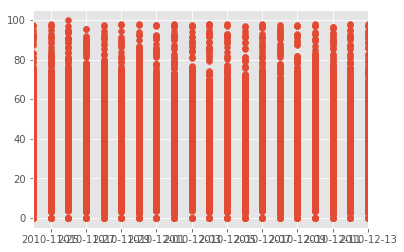

In [14]:
fig, ax = plt.subplots()
ax.scatter(raw_data["sample_time"].dt.date, raw_data["cpu_01_busy"])
ax.set_xlim(raw_data["sample_time"].dt.date.min(), 
           raw_data["sample_time"].dt.date.max())

In [16]:
raw_data.columns

Index(['sample_time', 'm_id', 'syst_direct_ipo_rate', 'syst_buffered_ipo_rate',
       'syst_page_fault_rate', 'syst_page_read_ipo_rate', 'syst_process_count',
       'syst_other_states', 'page_page_write_ipo_rate',
       'page_global_valid_fault_rate', 'page_free_list_size',
       'page_modified_list_size', 'io_mailbox_write_rate',
       'io_split_transfer_rate', 'io_file_open_rate', 'io_logical_name_trans',
       'io_page_reads', 'io_page_writes', 'page_free_list_faults',
       'page_modified_list_faults', 'page_demand_zero_faults', 'state_compute',
       'state_mwait', 'state_lef', 'state_hib', 'state_cur', 'app06_dirio',
       'app06_bufio', 'app06_pgflts', 'app06_proccount', 'app06_pagesgbl',
       'app06_pagesproc', 'app07_dirio', 'app07_bufio', 'app07_pgflts',
       'app07_proccount', 'app07_pagesgbl', 'app07_pagesproc', 'app04_dirio',
       'app04_bufio', 'app04_pgflts', 'app04_proccount', 'app04_pagesgbl',
       'app04_pagesproc', 'app08_dirio', 'app08_bufio', 'app0

# Simple Linear Model

In [239]:
raw_df = raw_data.copy()

In [240]:
raw_df["intercept"] = 1

In [241]:
ols_raw, ols_test = train_test_split(raw_df, test_size=0.33, random_state=3)


In [242]:
ols_train_y, ols_test_y = ols_raw["cpu_01_busy"], ols_test["cpu_01_busy"]

In [243]:
cols_of_interest.append("intercept")

In [246]:
cols_of_interest[-10:]

['hour', 'dow', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'intercept']

In [247]:
ols_cols_of_interest = cols_of_interest[0:-10]

In [249]:
olsX = ols_raw[ols_cols_of_interest].values

In [250]:
olsmodel = LinearRegression(fit_intercept=False)

In [251]:
olsmodel.fit(olsX, ols_train_y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [253]:
ols_yhat = olsmodel.predict(ols_test[ols_cols_of_interest])

In [254]:
(mean_squared_error(ols_test_y, ols_yhat))**0.5

5.4329332825306142

# Add time and day

In [192]:
time_df = raw_data.copy()

In [193]:
time_df["sample_time"] = pd.to_datetime(time_df["sample_time"])

In [203]:
time_df["dow"] = time_df["sample_time"].dt.dayofweek

In [205]:
time_df["hour"] = time_df["sample_time"].dt.hour

In [206]:
time_train, time_test = train_test_split(time_df, test_size=0.33, random_state=3)

In [207]:
time_train_y, time_test_y = time_train["cpu_01_busy"], time_test["cpu_01_busy"]

In [255]:
cols_of_interest

['syst_direct_ipo_rate',
 'syst_buffered_ipo_rate',
 'syst_page_fault_rate',
 'syst_page_read_ipo_rate',
 'syst_process_count',
 'syst_other_states',
 'page_page_write_ipo_rate',
 'page_global_valid_fault_rate',
 'page_free_list_size',
 'page_modified_list_size',
 'io_mailbox_write_rate',
 'io_split_transfer_rate',
 'io_file_open_rate',
 'io_logical_name_trans',
 'io_page_reads',
 'io_page_writes',
 'page_free_list_faults',
 'page_modified_list_faults',
 'page_demand_zero_faults',
 'state_compute',
 'state_mwait',
 'state_lef',
 'state_hib',
 'state_cur',
 'app06_dirio',
 'app06_bufio',
 'app06_pgflts',
 'app06_proccount',
 'app06_pagesgbl',
 'app06_pagesproc',
 'app07_dirio',
 'app07_bufio',
 'app07_pgflts',
 'app07_proccount',
 'app07_pagesgbl',
 'app07_pagesproc',
 'app04_dirio',
 'app04_bufio',
 'app04_pgflts',
 'app04_proccount',
 'app04_pagesgbl',
 'app04_pagesproc',
 'app08_dirio',
 'app08_bufio',
 'app08_pgflts',
 'app08_proccount',
 'app08_pagesgbl',
 'app08_pagesproc',
 'app0

In [258]:
time_cols_of_interest = cols_of_interest[0:-8]

In [259]:
time_cols_of_interest[-5:]

['ewc0_pkts_sentpsec',
 'ewd0_pkts_recvpsec',
 'ewd0_pkts_sentpsec',
 'hour',
 'dow']

In [260]:
timeX = time_train[time_cols_of_interest].values

In [261]:
time_model = LinearRegression()

In [262]:
time_model.fit(timeX, time_train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [263]:
time_test_X = time_test[time_cols_of_interest]

In [264]:
time_yhat = time_model.predict(time_test_X)

In [265]:
(mean_squared_error(time_test_y, time_yhat))**0.5

5.0161201971170177

# Model 4 - dummies for mid

In [286]:
mid_df = raw_data.copy()

In [287]:
mid_df["sample_time"] = pd.to_datetime(mid_df["sample_time"])
mid_df["dow"] = mid_df["sample_time"].dt.dayofweek
mid_df["hour"] = mid_df["sample_time"].dt.hour

In [288]:
mid_df2 = pd.concat([mid_df, pd.get_dummies(mid_df['m_id'])], axis=1) 

In [290]:
mid_train, mid_test = train_test_split(mid_df2, test_size=0.33, random_state=3)

In [270]:
cols_of_interest[-10:]

['hour', 'dow', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'intercept']

In [271]:
mid_cols_of_interest = cols_of_interest[0:-1]

In [229]:
cols_of_interest.extend(['a', 'b', 'c', 'd', 'e', 'f', 'g'])

In [295]:
mid_test_X = mid_test[mid_cols_of_interest].values
mid_train_X = mid_train[mid_cols_of_interest].values

In [296]:
mid_train_y, mid_test_y = mid_train["cpu_01_busy"], mid_test["cpu_01_busy"]

In [297]:
mid_model = LinearRegression()

In [299]:
mid_model.fit(mid_train_X, mid_train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [300]:
mid_test_yhat = mid_model.predict(mid_test_X)
mid_train_yhat = mid_model.predict(mid_train_X)

In [301]:
def print_RMSE(y_true_test, y_pred_test, y_true_train, y_pred_train):
    RMSE_train = mean_squared_error(y_true_train, y_pred_train) ** 0.5
    RMSE_test = mean_squared_error(y_true_test, y_pred_test) ** 0.5
    print('RMSE for Training Error: {}'.format(RMSE_train))
    print('RMSE for Testing Error: {}'.format(RMSE_test))

In [302]:
print_RMSE(mid_test_y, mid_test_yhat, mid_train_y, mid_train_yhat)

RMSE for Training Error: 5.085993828708801
RMSE for Testing Error: 5.072454337494467


# KFold Model 3

In [304]:
n_folds=10

cv_models = []
errors = []
splitter = KFold(n_splits=n_folds)

In [157]:
model = LinearRegression()

In [158]:
X = train_raw[cols_of_interest].values

In [159]:
X1 = np.append(np.ones([X.shape[0], 1]), X, axis = 1)

In [160]:
model.fit(X1, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [161]:
X_test = test_raw[cols_of_interest].values

In [162]:
X_test1 = np.append(np.ones([X_test1.shape[0], 1]), X_test, axis = 1)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [147]:
y_predicted = model.predict(X_test1)

ValueError: shapes (119782,88) and (87,) not aligned: 88 (dim 1) != 87 (dim 0)

In [112]:
(mean_squared_error(y_test, y_predicted))**0.5

10.238987841738112

In [113]:
model.score(X_test, y_test)

0.35004684368037653

In [69]:
spec_list = []
cols_of_interest = list(raw_data.columns[2:])
cols_of_interest.pop(cols_of_interest.index("cpu_01_busy"))
for col in cols_of_interest:
    col_spec = simple_spline_specification(col, list(np.linspace(raw_data[col].quantile(.07),
                                                                 raw_data[col].max(),
                                                                 3)))
    spec_list.append(col_spec)

In [70]:
fm = Pipeline([
    ('continuous_features', FeatureUnion([
        i for i in zip(raw_data.columns[2:], spec_list)]))
])

In [71]:
train_raw, test_raw = train_test_split(raw_data, test_size=0.33)
fm.fit(train_raw)
fm_train = fm.transform(train_raw)
fm_test = fm.transform(test_raw)

In [105]:
y_train, y_test = train_raw["cpu_01_busy"], test_raw["cpu_01_busy"]

In [68]:
fm_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119782 entries, 18155 to 112464
Columns: 516 entries, syst_direct_ipo_rate_spline_linear to ewd0_pkts_sentpsec_spline_4
dtypes: float64(516)
memory usage: 472.5 MB


In [66]:
fm_train.columns

Index(['syst_direct_ipo_rate_spline_linear', 'syst_direct_ipo_rate_spline_0',
       'syst_direct_ipo_rate_spline_1', 'syst_direct_ipo_rate_spline_2',
       'syst_direct_ipo_rate_spline_3', 'syst_direct_ipo_rate_spline_4',
       'syst_buffered_ipo_rate_spline_linear',
       'syst_buffered_ipo_rate_spline_0', 'syst_buffered_ipo_rate_spline_1',
       'syst_buffered_ipo_rate_spline_2',
       ...
       'ewd0_pkts_recvpsec_spline_1', 'ewd0_pkts_recvpsec_spline_2',
       'ewd0_pkts_recvpsec_spline_3', 'ewd0_pkts_recvpsec_spline_4',
       'ewd0_pkts_sentpsec_spline_linear', 'ewd0_pkts_sentpsec_spline_0',
       'ewd0_pkts_sentpsec_spline_1', 'ewd0_pkts_sentpsec_spline_2',
       'ewd0_pkts_sentpsec_spline_3', 'ewd0_pkts_sentpsec_spline_4'],
      dtype='object', length=516)

In [74]:
ridge_regularization_strengths = np.logspace(np.log10(0.000001), np.log10(10000), num=100)

ridge_regressions = []
for alpha in ridge_regularization_strengths:
    print(alpha)
    ridge = Ridge(alpha=alpha)
    ridge.fit(fm_train, y_train)
    ridge_regressions.append(ridge)

1e-06


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').